https://medium.com/@nygeog/data-science-methods-focus-geoprocessing-with-geopandas-using-spatial-joins-counting-points-e42d1b36d758

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
plt.style.use('ggplot')

Points

In [3]:
nyc_wifi_geojson = "https://data.cityofnewyork.us/resource/yjub-udmw.geojson"
nyc_wifi = gpd.read_file(nyc_wifi_geojson)
# note json response only includes first 1000 by default in socrata api
nyc_wifi[['provider', 'latitude', 'longitude']].head(5)

,provider,latitude,longitude
0,SPECTRUM,40.67485999990,-73.78412000050
1,SPECTRUM,40.74755999960,-73.81814999970
2,Transit Wireless,40.71192599970,-73.94066999940
3,Downtown Brooklyn,40.68998500010,-73.99199500040
4,Transit Wireless,40.76463000020,-73.96611500010


In [4]:
nyc_wifi.columns
# note that borocd is the community district id, as nyc gov already joined this data for
# but for this purpose we will ignore this borocd column

Index(['x', 'city', 'name', 'activated', 'ntacode', 'location_lat_long_city',
       'location', 'provider', 'latitude', 'zip', 'coundist',
       'location_lat_long_state', 'y', 'bctcb2010', 'ntaname', 'location_t',
       'ssid', 'bbl', 'borocd', 'objectid', 'longitude',
       'location_lat_long_address', 'boroname', 'sourceid',
       'location_lat_long_zip', 'remarks', 'ct2010', 'borocode', 'bin', 'type',
       'doitt_id', 'borough', 'geometry'],
      dtype='object')

In [5]:
nyc_wifi = nyc_wifi.to_crs(epsg=2263)  
# set to nyc projection system

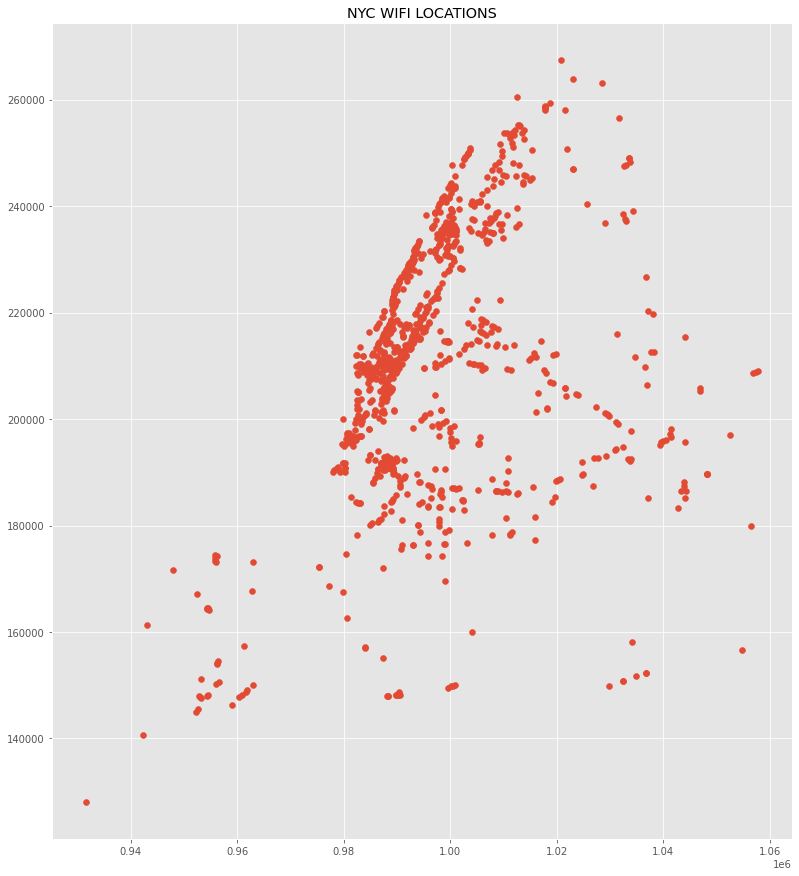

In [6]:
nyc_wifi.plot(figsize=(15, 15))
plt.title('NYC WIFI LOCATIONS');

In [7]:
nyc_community_districts_geojson = 'https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=GeoJSON'
nyc_community_districts = gpd.read_file(nyc_community_districts_geojson)
nyc_community_districts.head(10)  # let's check out the data

,boro_cd,shape_area,shape_leng,geometry
0,206,42664311.5086,35875.7117328,"MULTIPOLYGON (((-73.87185 40.84376, -73.87192 ..."
1,404,65739661.969,37018.3738392,"MULTIPOLYGON (((-73.84751 40.73901, -73.84801 ..."
2,304,56662613.1611,37007.806599,"MULTIPOLYGON (((-73.89647 40.68234, -73.89653 ..."
3,205,38316975.1292,29443.0481287,"MULTIPOLYGON (((-73.89138 40.86170, -73.89142 ..."
4,207,53311689.1,44812.1474256,"MULTIPOLYGON (((-73.87519 40.87158, -73.87619 ..."
5,208,92071723.6338,47817.4255674,"MULTIPOLYGON (((-73.89663 40.91142, -73.89663 ..."
6,483,191997989.517,106865.645248,"MULTIPOLYGON (((-73.74694 40.63755, -73.74694 ..."
7,303,79461502.4768,36213.6712642,"MULTIPOLYGON (((-73.91805 40.68721, -73.91800 ..."
8,412,267333306.426,65928.4103495,"MULTIPOLYGON (((-73.80168 40.66632, -73.80167 ..."
9,107,53152583.3496,39863.7028994,"MULTIPOLYGON (((-73.95965 40.80116, -73.95883 ..."


In [8]:
nyc_community_districts.shape
# there are 71 community districts in nyc, boro_cd is the unique id, 
# there are actually ~59, but some are park features, airports, etc

(71, 4)

In [9]:
nyc_community_districts = nyc_community_districts.to_crs(epsg=2263) 
# set to nyc projection system

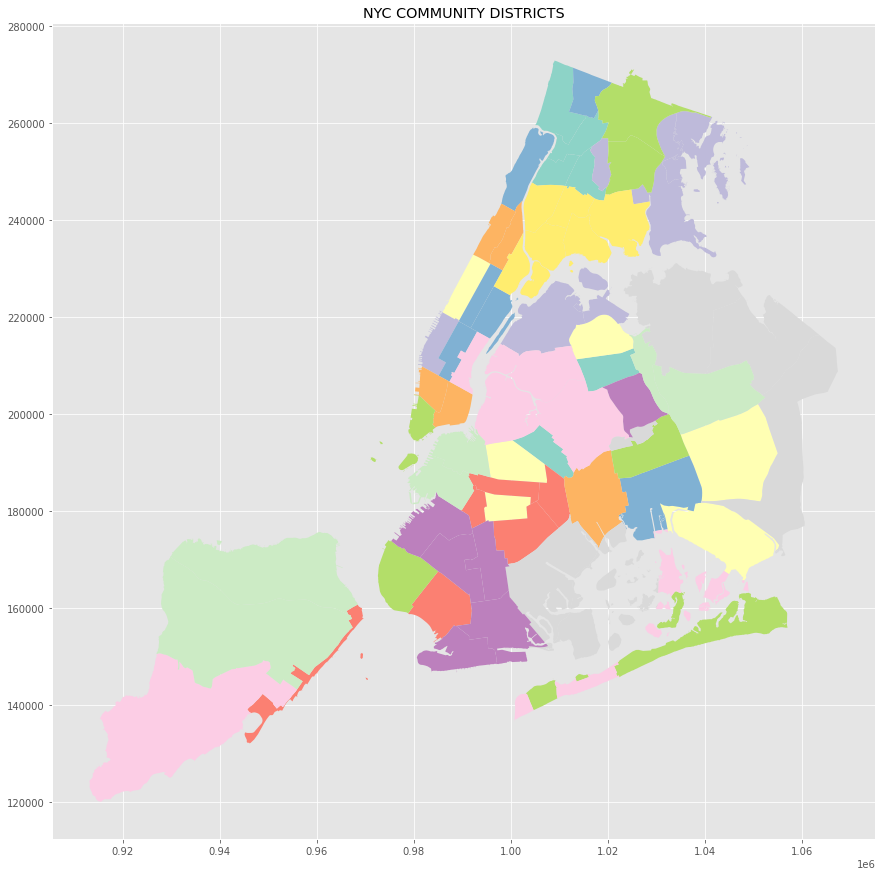

In [10]:
nyc_community_districts.plot(figsize=(15, 15), cmap='Set3')
plt.title('NYC COMMUNITY DISTRICTS');

<AxesSubplot:>

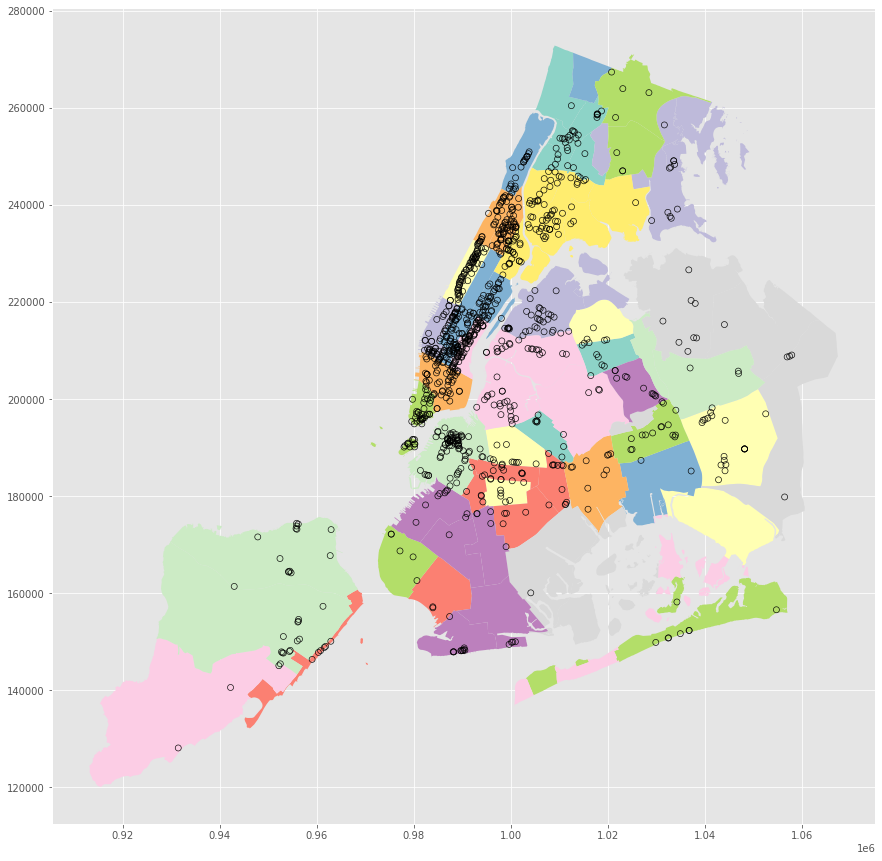

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
nyc_community_districts.plot(cmap='Set3', ax=ax)  # plot on the same ax
nyc_wifi.plot(
    facecolors='none', 
    ax=ax, 
    alpha=0.9, 
    edgecolor='black', 
    linewidth=0.7, 
)  # plot on the same axplt.title('COUNT WIFI LOCATIONS IN NYC COMMUNITY DISTRICTS');

In [12]:
joined_df = gpd.sjoin(
    nyc_wifi,
    nyc_community_districts,
    how='inner',
    op='intersects',
)

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
com_dist_count_wifi_locs = joined_df.groupby(
    ['boro_cd'], 
    as_index=False,
)['doitt_id'].count()
# groupby to count the wifi locations in each community district
# arbitrarily count the rows for doitt_id
com_dist_count_wifi_locs.columns = ['boro_cd', 'count_wifi_locations']
# rename the column
com_dist_count_wifi_locs.head(10)

,boro_cd,count_wifi_locations
0,101,47
1,102,22
2,103,25
3,104,46
4,105,78
5,106,65
6,107,65
7,108,40
8,109,26
9,110,52


In [14]:
com_dists_wifi_counts = nyc_community_districts.merge(
    com_dist_count_wifi_locs, 
    on='boro_cd', 
    how='left', 
)
# merge left back to nyc_community_districts layer
com_dists_wifi_counts.head()

,boro_cd,shape_area,shape_leng,geometry,count_wifi_locations
0,206,42664311.5086,35875.7117328,"MULTIPOLYGON (((1019707.979 246708.141, 101968...",6.0
1,404,65739661.969,37018.3738392,"MULTIPOLYGON (((1026508.290 208553.862, 102636...",7.0
2,304,56662613.1611,37007.806599,"MULTIPOLYGON (((1012965.523 187886.949, 101294...",7.0
3,205,38316975.1292,29443.0481287,"MULTIPOLYGON (((1014295.119 253236.989, 101428...",10.0
4,207,53311689.1,44812.1474256,"MULTIPOLYGON (((1018768.756 256840.862, 101849...",16.0


In [15]:
com_dists_wifi_counts.isnull().sum()  
# there are 8 community districts with no wifi locations

boro_cd                 0
shape_area              0
shape_leng              0
geometry                0
count_wifi_locations    8
dtype: int64

In [16]:
com_dists_wifi_counts['count_wifi_locations'].fillna(
    0, 
    inplace=True,
)  
# fill in missing's with 0, valid in this case.

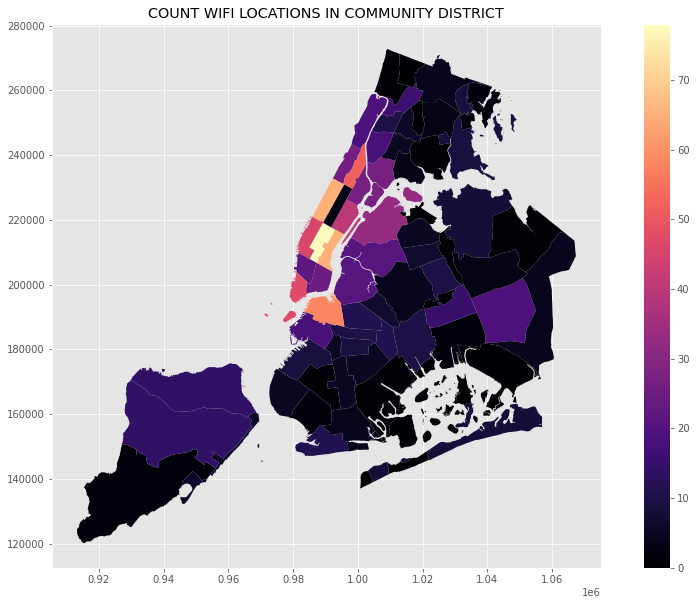

In [17]:
com_dists_wifi_counts.plot(
    column='count_wifi_locations', 
    figsize=(15, 10),
    cmap='magma',
    legend=True,
)
plt.title('COUNT WIFI LOCATIONS IN COMMUNITY DISTRICT');